In [11]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import medial_axis
import cv2 as cv
from time import time

In [12]:
MIN_MATCH_COUNT = 3



sift = cv.SIFT_create()

In [13]:
path = 'imgs/uni/'

img_ext = '.jpg'
imgnumber = 3
resize_factor = 1

# Leer las imágenes en color y escala de grises
im_color = []  # Para visualización y costura
im_gray = []   # Para procesamiento de homografías, etc.
for i in range(1, imgnumber + 1):
    full_name = path + str(i) + img_ext

    # Leer la imagen en color y redimensionarla
    img_color = cv.imread(full_name)
    img_color = cv.resize(img_color, (0, 0), fx=resize_factor, fy=resize_factor)

    # Leer la imagen en escala de grises y redimensionarla
    img_gray = cv.imread(full_name, cv.IMREAD_GRAYSCALE)
    img_gray = cv.resize(img_gray, (0, 0), fx=resize_factor, fy=resize_factor)

    # Añadir imágenes redimensionadas a las listas
    im_color.append(img_color)
    im_gray.append(img_gray)

In [14]:
shapes = np.zeros((imgnumber,2)).astype(int)

for i in range(imgnumber):
    shapes[i,:] = im_gray[i].shape[:2]

print(shapes)

[[1600 1200]
 [1600 1200]
 [1600 1200]]


In [15]:
kps =[] 
des = []

for i in range(imgnumber):
    kp, ds = sift.detectAndCompute(im_gray[i],None)
    kps.append(kp)
    des.append(ds)
    print('Image ' + str(i) + ' has ' + str(len(kp)) + ' keypoints')

Image 0 has 963 keypoints
Image 1 has 1007 keypoints
Image 2 has 1260 keypoints


In [16]:
bf = cv.BFMatcher()

matches = []
goods = []

for i in range(imgnumber-1):
    matches.append(bf.knnMatch(des[i],des[i+1],k=2))

    print("Total matches from image {} to image {} are {}".format(i,i+1,len(matches[i])))

    good = []

    for m,n in matches[i]:
        if m.distance < 0.75*n.distance:
            good.append(m)

    goods.append(good)
    print("Good matches from image {} to image {} are {}".format(i,i+1,len(good)))

Total matches from image 0 to image 1 are 963
Good matches from image 0 to image 1 are 266
Total matches from image 1 to image 2 are 1007
Good matches from image 1 to image 2 are 296


Imagen 0: escala de grises.
Imagen 1: escala de grises.
Imagen 2: escala de grises.


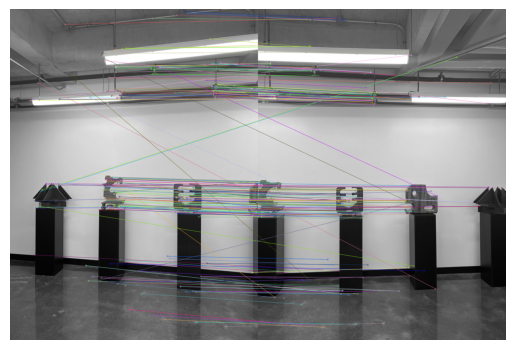

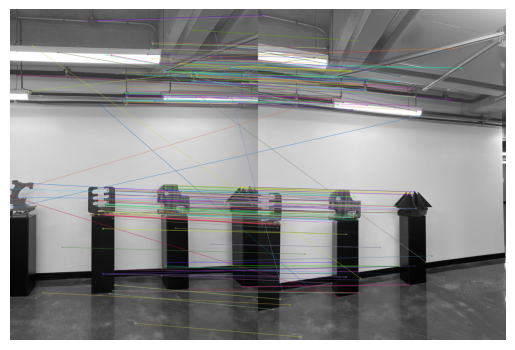

In [17]:
import matplotlib.pyplot as plt
import cv2 as cv

# Verificar que las imágenes originales sean en color y que tengan 3 canales
for i, img in enumerate(im_gray):
    if len(img.shape) == 2:
        print(f"Imagen {i}: escala de grises.")
    elif img.shape[2] == 3:
        print(f"Imagen {i}: color (3 canales).")

# Procesamiento de coincidencias
# Dibuja coincidencias entre imágenes y muestra en color
# Dibuja coincidencias entre imágenes y muestra en color
for i in range(1, imgnumber):
    if len(goods[i - 1]) > 0:
        # Dibuja las coincidencias utilizando imágenes en color, pero basándose en puntos clave en escala de grises
        draw = cv.drawMatches(im_gray[i - 1], kps[i - 1], im_gray[i], kps[i], goods[i - 1], im_color[i - 1], flags=2)

        # Convierte de BGR a RGB para mostrarlo en matplotlib
        draw_rgb = cv.cvtColor(draw, cv.COLOR_BGR2RGB)

        # Mostrar usando matplotlib
        plt.imshow(draw_rgb)
        plt.axis('off')
        plt.show()
    else:
        print(f"No good matches between image {i} and {i - 1}.")

## Estimate Homographies

In [18]:

def FindHomography(Matches, BaseImage_kp, SecImage_kp):
    # If less than 4 matches found, exit the code.
    if len(Matches) < 4:
        print("\nNot enough matches found between the images.\n")
        exit(0)

    # Storing coordinates of points corresponding to the matches found in both the images
    BaseImage_pts = []
    SecImage_pts = []
    for Match in Matches:
        BaseImage_pts.append(BaseImage_kp[Match.queryIdx].pt)
        SecImage_pts.append(SecImage_kp[Match.trainIdx].pt)

    # Changing the datatype to "float32" for finding homography
    BaseImage_pts = np.float32(BaseImage_pts)
    SecImage_pts = np.float32(SecImage_pts)

    # Finding the homography matrix(transformation matrix).
    (HomographyMatrix, Status) = cv.findHomography(
        SecImage_pts, BaseImage_pts, cv.RANSAC, 4.0)

    return HomographyMatrix, Status


In [19]:
H = [np.eye(3)]  

for i in range(1, imgnumber):
    # Verificar si hay suficientes coincidencias
    if len(goods[i - 1]) >= MIN_MATCH_COUNT:
        # Encontrar la homografía entre las imágenes i e i-1

        H_i, status = FindHomography(goods[i - 1], kps[i - 1], kps[i])
        H.append(H_i)
        print(f"Homography matrix between image {i} and {i-1} is:\n{H_i}")

Homography matrix between image 1 and 0 is:
[[ 7.17458988e-01 -1.31200270e-02  4.65096673e+02]
 [-1.75172730e-01  9.19556049e-01  4.50766386e+01]
 [-2.36546625e-04  3.57581135e-06  1.00000000e+00]]
Homography matrix between image 2 and 1 is:
[[ 7.39297822e-01  2.03000730e-02  3.98514468e+02]
 [-1.83024012e-01  9.34716817e-01  3.88813151e+01]
 [-2.27501742e-04  1.73518582e-05  1.00000000e+00]]


In [20]:
for i in range(0,imgnumber):
    print(H[i])

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[ 7.17458988e-01 -1.31200270e-02  4.65096673e+02]
 [-1.75172730e-01  9.19556049e-01  4.50766386e+01]
 [-2.36546625e-04  3.57581135e-06  1.00000000e+00]]
[[ 7.39297822e-01  2.03000730e-02  3.98514468e+02]
 [-1.83024012e-01  9.34716817e-01  3.88813151e+01]
 [-2.27501742e-04  1.73518582e-05  1.00000000e+00]]


In [21]:
# # change panorama tro based at central image
# center = imgnumber//2
# if (center > 0):
#     for i in range(imgnumber):
#         H[i] = np.linalg.inv(H[center]) @ H[i]
    
#     H[center] = np.eye(3)

In [22]:
# print('Homographies adjusted to central image')
# for i in range(imgnumber):
#     print(H[i])

In [23]:
import numpy as np
import cv2 as cv

def update_homography(H, new_H):
    """ Actualiza la matriz de homografía acumulada con una nueva transformación. """
    return np.dot(new_H, H)

def calculate_final_frame_size(homographies, image_shapes):
    """ Calcula el tamaño del marco final basado en todas las transformaciones y tamaños de imagen. """
    min_x, min_y = 0, 0
    max_x, max_y = 0, 0
    
    # Iniciar con la primera imagen, que está sin transformar.
    (h, w) = image_shapes[0]
    corners = np.float32([[0, 0, 1], [w, 0, 1], [w, h, 1], [0, h, 1]]).T
    
    # Evaluar los límites de las esquinas de la primera imagen.
    for i in range(len(homographies)):
        transformed_corners = np.dot(homographies[i], corners)
        transformed_corners /= transformed_corners[2]  # Normalizar
        
        x = transformed_corners[0, :]
        y = transformed_corners[1, :]
        
        min_x = min(min_x, min(x))
        max_x = max(max_x, max(x))
        min_y = min(min_y, min(y))
        max_y = max(max_y, max(y))
    
    width = int(np.ceil(max_x - min_x))
    height = int(np.ceil(max_y - min_y))
    
    return (width, height)

# Lista de matrices de homografía y tamaños de imagen
homographies = [np.eye(3)]  # Inicializar con la matriz identidad para la primera imagen

# Supongamos que tienes una lista `H` que contiene las homografías entre pares consecutivos de imágenes
for H_pair in H[1:]:
    homographies.append(update_homography(homographies[-1], H_pair))

# Supongamos que `shapes` contiene los tamaños (altura, anchura) de cada imagen
image_shapes = shapes

# Calcular el tamaño del marco final
final_frame_size = calculate_final_frame_size(homographies, image_shapes)
print("El tamaño del marco final es:", final_frame_size)


El tamaño del marco final es: (3068, 3154)


C:\Users\josem\AppData\Local\Temp\ipykernel_1652\3760856306.py:74: RuntimeWarning: invalid value encountered in divide
  stitched_image /= np.stack([weight_sum]*3, axis=-1)
C:\Users\josem\AppData\Local\Temp\ipykernel_1652\3760856306.py:76: RuntimeWarning: invalid value encountered in cast
  return stitched_image.astype(np.uint8)  # Convertir a uint8 para mostrar en matplotlib


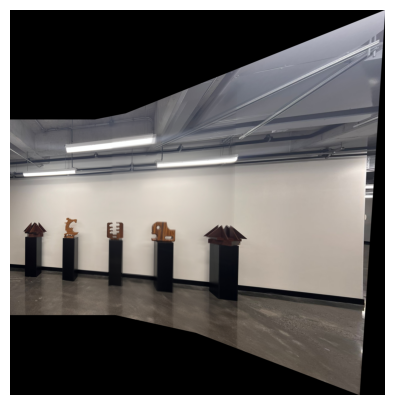

In [24]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def calculate_correction(homographies, image_shapes):
    """ Calcula el tamaño del marco final y las correcciones necesarias basadas en todas las transformaciones. """
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = float('-inf'), float('-inf')
    
    for i, H in enumerate(homographies):
        h, w = image_shapes[i]
        corners = np.array([
            [0, 0, 1],
            [w - 1, 0, 1],
            [w - 1, h - 1, 1],
            [0, h - 1, 1]
        ]).T
        transformed_corners = np.dot(H, corners)
        transformed_corners /= transformed_corners[2, :]  # Normalización
        
        min_x = min(min_x, np.min(transformed_corners[0, :]))
        max_x = max(max_x, np.max(transformed_corners[0, :]))
        min_y = min(min_y, np.min(transformed_corners[1, :]))
        max_y = max(max_y, np.max(transformed_corners[1, :]))
    
    translation = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    corrected_homographies = [np.dot(translation, H) for H in homographies]
    width = int(np.ceil(max_x - min_x))
    height = int(np.ceil(max_y - min_y))
    
    return (width, height), corrected_homographies

# def stitch_images(images, homographies, frame_size):
#     stitched_image = np.zeros((frame_size[1], frame_size[0], 3), dtype=np.uint8)
    
#     for i, image in enumerate(images):
#         if len(image.shape) == 2:
#             image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
#         transformed_image = cv.warpPerspective(image, homographies[i], (frame_size[0], frame_size[1]))
#         mask = (transformed_image > 0)[..., 0]
#         stitched_image[mask] = transformed_image[mask]
        
#     return stitched_image


def stitch_images(images, homographies, frame_size):
    """ Junta las imagenes y realiza blending de fusion lineal """
    # Crear una imagen panorámica con un dtype que permite float para blending
    stitched_image = np.zeros((frame_size[1], frame_size[0], 3), dtype=np.float32)
    
    # Usaremos también un acumulador para normalizar la imagen al final
    weight_sum = np.zeros((frame_size[1], frame_size[0]), dtype=np.float32)
    
    for i, image in enumerate(images):
        if len(image.shape) == 2:
            image = cv.cvtColor(image, cv.COLOR_GRAY2BGR)
        
        transformed_image = cv.warpPerspective(image, homographies[i], (frame_size[0], frame_size[1]))
        
        # Crear una máscara de peso lineal (blending de feathering)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
        cv.rectangle(mask, (10, 10), (mask.shape[1]-10, mask.shape[0]-10), 1, thickness=cv.FILLED)
        mask = cv.GaussianBlur(mask, (51, 51), 0)
        
        transformed_mask = cv.warpPerspective(mask, homographies[i], (frame_size[0], frame_size[1]))
        
        # Aplicar la máscara a la imagen transformada y sumar al panorama
        for c in range(3):  # Aplicar la máscara a cada canal
            stitched_image[..., c] += transformed_image[..., c] * transformed_mask
        
        weight_sum += transformed_mask
    
    # Normalizar el resultado final
    stitched_image /= np.stack([weight_sum]*3, axis=-1)
    
    return stitched_image.astype(np.uint8)  # Convertir a uint8 para mostrar en matplotlib

# Asumiendo que `im_color` contiene las imágenes y `homographies` las transformaciones
image_shapes = [(img.shape[0], img.shape[1]) for img in im_color]
final_frame_size, corrected_homographies = calculate_correction(homographies, image_shapes)
panoramic_image = stitch_images(im_color, corrected_homographies, final_frame_size)

# Usar matplotlib para mostrar la imagen
plt.figure(figsize=(10, 5))  # Puedes ajustar el tamaño de la figura aquí
plt.imshow(cv.cvtColor(panoramic_image, cv.COLOR_BGR2RGB))
plt.axis('off')  # Ocultar los ejes
plt.show()
